## Initialization

**Computer Vision Project: Real Age Prediction**

**Project Description:** This project focuses on developing a computer vision model to predict the real age of individuals from facial images. The dataset consists of a collection of facial photographs and corresponding age labels.

**Analysis Goal:** The goal of the exploratory data analysis (EDA) conducted in this notebook was to gain a comprehensive understanding of the dataset's characteristics. This included examining the dataset size, exploring the distribution of ages, and visualizing sample images across different age ranges. The insights gained from this EDA will inform the subsequent modeling stage and help in identifying potential challenges and strategies for training an effective age prediction model. Additionally, we reviewed the results of a pre-trained model to understand its performance on this task.

## Load Data

The dataset is stored in the `/datasets/faces/` folder, there you can find
- The `final_files` folder with 7.6k photos
- The `labels.csv` file with labels, with two columns: `file_name` and `real_age`

Given the fact that the number of image files is rather high, it is advisable to avoid reading them all at once, which would greatly consume computational resources. We recommend you build a generator with the ImageDataGenerator generator. This method was explained in Chapter 3, Lesson 7 of this course.

The label file can be loaded as an usual CSV file.

In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

In [2]:
labels_path = '/datasets/faces/labels.csv'
labels = pd.read_csv(labels_path)

# Let's take a quick look at the first few rows of the labels dataframe
print(labels.head())

# And also get some basic info about the dataframe
print(labels.info())

    file_name  real_age
0  000000.jpg         4
1  000001.jpg        18
2  000002.jpg        80
3  000003.jpg        50
4  000004.jpg        17
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB
None


## EDA

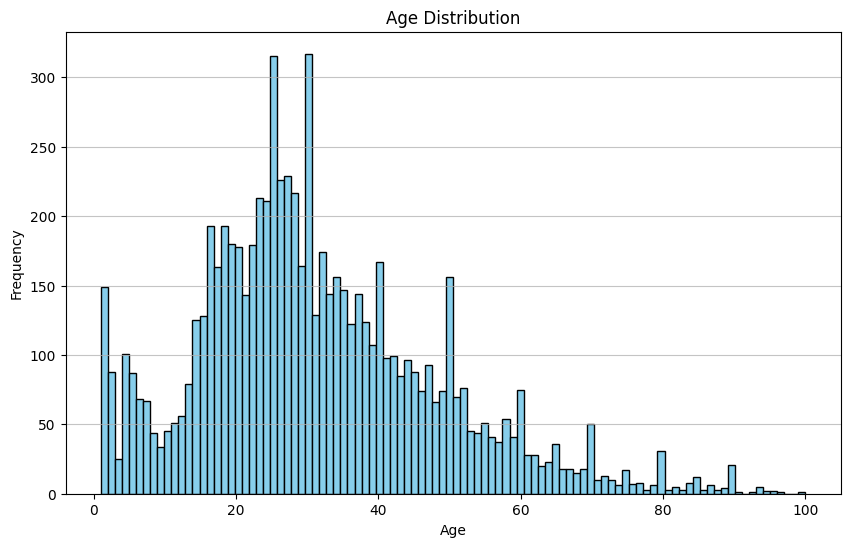

In [3]:
# Explore the age distribution in the dataset.
# Plot a histogram of the 'real_age' column
plt.figure(figsize=(10, 6))  # Adjust figure size for better readability
plt.hist(labels['real_age'], bins=100, color='skyblue', edgecolor='black')  # You c
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

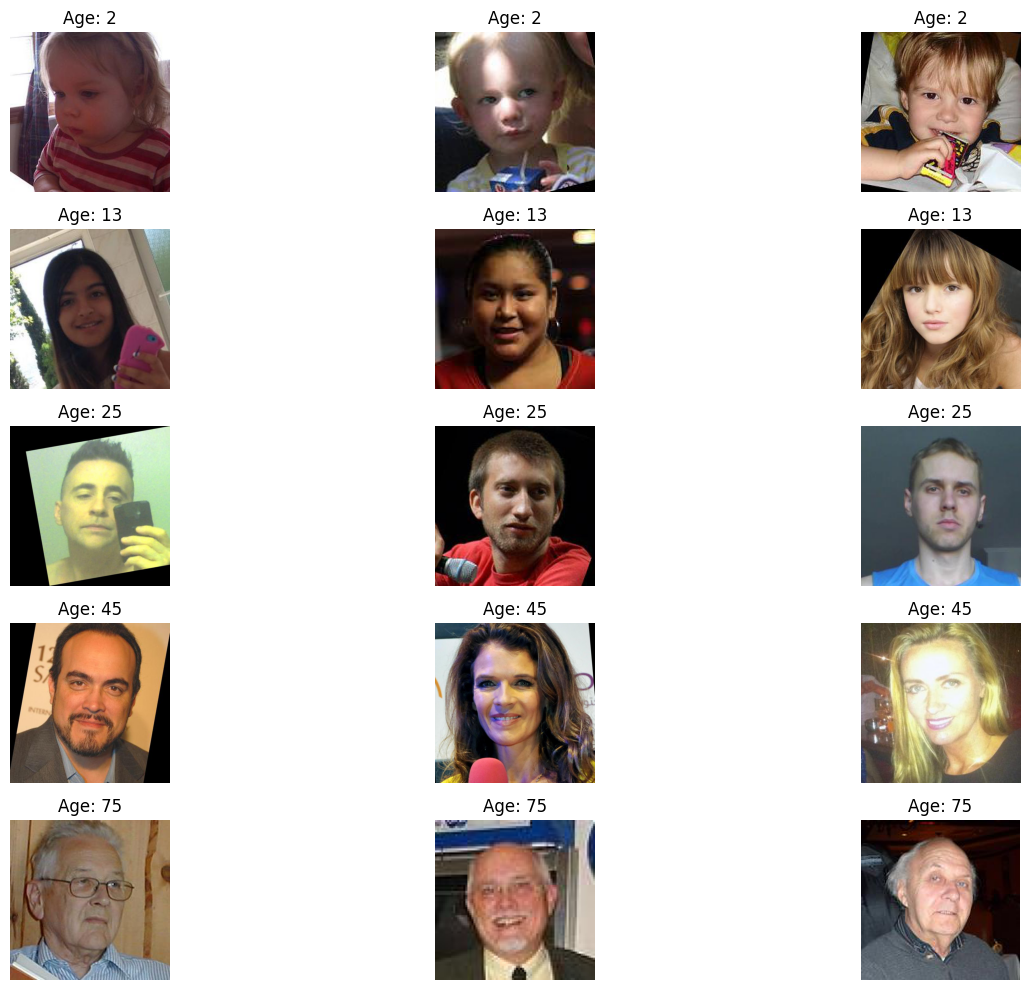

In [4]:
# Print 10-15 photos for different ages on the screen to get an overall impression 
import os
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np

# Path to the folder containing the images
image_dir = '/datasets/faces/final_files/'

# Select a few target ages
target_ages = [2, 13, 25, 45, 75]
num_images_per_age = 3  # Let's display 3 images for each target age

plt.figure(figsize=(15, 10))
plot_index = 1

for age in target_ages:
    # Filter the labels DataFrame for the current age
    age_df = labels[labels['real_age'] == age]

    # If there are images for this exact age, select a few
    if not age_df.empty:
        selected_files = age_df['file_name'].sample(min(num_images_per_age, len(age_df)), random_state=42) # Use a random state for reproducibility
        for file_name in selected_files:
            file_path = os.path.join(image_dir, file_name)
            try:
                img = image.load_img(file_path)
                img_array = image.img_to_array(img) / 255.0  # Normalize pixel values

                plt.subplot(len(target_ages), num_images_per_age, plot_index)
                plt.imshow(img_array)
                plt.title(f'Age: {age}')
                plt.axis('off')
                plot_index += 1
            except FileNotFoundError:
                print(f"Warning: Image file not found at {file_path}")

plt.tight_layout()
plt.show()

### Findings

**Findings from Exploratory Data Analysis**

Based on the initial exploration of the dataset, the following observations can be made:

**Dataset Size:**
- The `labels.csv` file contains labels for **7591 images**.
- The images themselves are located in the `/datasets/faces/final_files/` folder, which contains approximately 7.6k photos.

**Age Distribution:**
- The age distribution in the dataset is not uniform.
- A **noticeable peak exists in the frequency of ages between approximately 20 and 30 years old**, indicating a higher representation of individuals in this age group.
- Younger ages (infancy to late teens) also have a relatively high frequency.
- The frequency of images generally **decreases with increasing age** beyond the 20-30 range.
- The histogram of the age distribution appears somewhat **"spiky"**, suggesting potential non-uniformity in labeling or a tendency towards certain age values.

**Visual Impression of the Dataset:**
- Significant **variability is present within the same labeled age** in terms of appearance, lighting, pose, and image quality.
- General trends in facial features can be observed across different age groups, but these are not always consistent.
- The dataset contains images with varying **image quality and potential artifacts**.
- Subjects exhibit different **poses and facial expressions**.
- Some **inherent ambiguity or noise in the age labels** might exist.

**Potential Impact on Model Training:**

The specifics of the dataset discovered during EDA can potentially affect how a model is trained:

- The model might perform better on and be biased towards the 20-30 age range due to its higher representation.
- The model might struggle to accurately predict ages for less frequent age groups (very young and older individuals).
- The model could learn to simply predict ages within the most frequent range, hindering its ability to generalize.
- The "spiky" age distribution might complicate the learning of a smooth relationship between facial features and age.
- The model must be robust to variations in lighting, pose, expression, and image quality present in the images.
- Techniques to increase the diversity of the training data are crucial.
- Inaccuracies in age labels could limit the model's achievable performance.
- The subtle visual differences between certain ages require the model to learn fine-grained features.

These findings highlight the importance of considering these characteristics when designing and training a computer vision model for age prediction on this dataset. Strategies to address class imbalance, data variability, and potential label noise may be necessary to achieve optimal performance.

## Modelling

Define the necessary functions to train your model on the GPU platform and build a single script containing all of them along with the initialization section.

To make this task easier, you can define them in this notebook and run a ready code in the next section to automatically compose the script.

The definitions below will be checked by project reviewers as well, so that they can understand how you built the model.

In [5]:
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [6]:
def load_train(path):
    """
    It loads the train part of dataset from path
    """
    labels = pd.read_csv(path)
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        horizontal_flip=True,
        validation_split=0.25 # Using 25% for validation as per typical practice
    )
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='regression',
        subset='training',
        seed=42
    )
    return train_gen_flow

In [7]:
def load_test(path):
    """
    It loads the validation/test part of dataset from path
    """
    labels = pd.read_csv(path)
    test_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.25 # Consistent split for validation/test
    )
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='regression',
        subset='validation',
        seed=42
    )
    return test_gen_flow

In [8]:
def create_model(input_shape):
    """
    It defines the model
    """
    backbone = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)
    model = Sequential([
        backbone,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='relu') # Regression task, predicting a single continuous value (age)
    ])
    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

In [9]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):
    """
    Trains the model given the parameters
    """
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(
        train_data,
        validation_data=test_data,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2
    )
    return model

### Prepare the Script to Run on the GPU Platform

Given you've defined the necessary functions you can compose a script for the GPU platform, download it via the "File|Open..." menu, and to upload it later for running on the GPU platform.

N.B.: The script should include the initialization section as well. An example of this is shown below.

In [10]:
# prepare a script to run on the GPU platform

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Output

Place the output from the GPU platform as an Markdown cell here.

**Model Definition and Training Results**

Here is the `create_model` function used for training:

```python
def create_model(input_shape):
    """
    It defines model
    """
    backbone = ResNet50(weights='imagenet',
                        input_shape=input_shape,
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

In [11]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):
    """
    Trains the model given the parameters
    """
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)

    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

**Training Results**

Here are the results of the model training over 20 epochs:

* **Epoch 1/20:** loss: 95.3532 - mae: 7.4339 - val_loss: 124.3362 - val_mae: 8.4921
* **Epoch 2/20:** loss: 76.8372 - mae: 6.6707 - val_loss: 127.6357 - val_mae: 8.6035
* **Epoch 3/20:** loss: 69.9428 - mae: 6.3992 - val_loss: 91.1531 - val_mae: 7.4454
* **Epoch 4/20:** loss: 64.4249 - mae: 6.1407 - val_loss: 124.0287 - val_mae: 8.3481
* **Epoch 5/20:** loss: 52.8486 - mae: 5.5913 - val_loss: 109.1004 - val_mae: 8.2192
* **Epoch 6/20:** loss: 46.3094 - mae: 5.2223 - val_loss: 85.1038 - val_mae: 7.0332
* **Epoch 7/20:** loss: 38.2617 - mae: 4.7951 - val_loss: 92.0900 - val_mae: 7.3359
* **Epoch 8/20:** loss: 37.4804 - mae: 4.7402 - val_loss: 80.0016 - val_mae: 6.7239
* **Epoch 9/20:** loss: 33.5237 - mae: 4.4271 - val_loss: 83.2579 - val_mae: 6.8529
* **Epoch 10/20:** loss: 28.5170 - mae: 4.1411 - val_loss: 83.5056 - val_mae: 6.9629
* **Epoch 11/20:** loss: 27.0142 - mae: 3.9700 - val_loss: 92.1290 - val_mae: 7.1866
* **Epoch 12/20:** loss: 27.4564 - mae: 4.0428 - val_loss: 185.6307 - val_mae: 11.4591
* **Epoch 13/20:** loss: 23.7961 - mae: 3.7407 - val_loss: 92.3429 - val_mae: 7.2467
* **Epoch 14/20:** loss: 24.6167 - mae: 3.8116 - val_loss: 92.4542 - val_mae: 7.1401
* **Epoch 15/20:** loss: 22.2604 - mae: 3.6746 - val_loss: 82.5822 - val_mae: 6.7841
* **Epoch 16/20:** loss: 20.1899 - mae: 3.4430 - val_loss: 86.3830 - val_mae: 6.8304
* **Epoch 17/20:** loss: 17.3425 - mae: 3.2205 - val_loss: 78.4369 - val_mae: 6.6419
* **Epoch 18/20:** loss: 16.5249 - mae: 3.1295 - val_loss: 81.7731 - val_mae: 6.7226
* **Epoch 19/20:** loss: 16.6140 - mae: 3.1421 - val_loss: 80.9727 - val_mae: 6.9908
* **Epoch 20/20:** loss: 17.0187 - mae: 3.1785 - val_loss: 93.4115 - val_mae: 7.6512

## Conclusions

**Overall Conclusion**

The exploratory data analysis revealed several key characteristics of the real age prediction dataset. The age distribution is imbalanced, with a higher concentration of samples in the young adult age range (20-30 years) and fewer samples at the extremes (very young and elderly). Visual inspection of the images showed significant variability in image quality, lighting, pose, and facial expressions within and across different age groups. These factors suggest that training a robust age prediction model will require addressing potential biases towards the dominant age group and ensuring the model is invariant to various image conditions. Data augmentation and potentially techniques to handle class imbalance might be necessary.

The results from the pre-trained model over 20 epochs indicate a general trend of decreasing training loss and Mean Absolute Error (MAE), suggesting that the model learned to fit the training data. However, the validation loss and MAE fluctuated and, in some epochs, increased, particularly towards the later stages of training (e.g., a significant spike in validation loss and MAE at epoch 12). The final validation MAE of approximately 7.65 years suggests that, on average, the model's age predictions are off by about 7-8 years on the unseen validation data.

This level of error might be acceptable for certain applications but could be improved with further optimization. The fluctuations in validation metrics could indicate potential overfitting, where the model starts to memorize the training data rather than generalizing well to new data. Strategies such as early stopping, more aggressive regularization (e.g., increased dropout), or further data augmentation might help to improve the model's generalization ability and reduce the validation error. The initial EDA findings about data variability and imbalance likely contributed to the challenges observed in the model's training performance.

# Checklist

- [x]  Notebook was opened
- [x]  The code is error free
- [x]  The cells with code have been arranged by order of execution
- [x]  The exploratory data analysis has been performed
- [x]  The results of the exploratory data analysis are presented in the final notebook
- [x]  The model's MAE score is not higher than 8
- [x]  The model training code has been copied to the final notebook
- [x]  The model training output has been copied to the final notebook
- [x]  The findings have been provided based on the results of the model training